In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get chord annotation
import autorootcwd
from src.utils import get_raw_chord_annotation, get_filenames, get_raw_beats
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def estimate_bpm(beats):
    """
    Given a list (or np.array) of beat times in seconds, 
    estimate BPM (Beats Per Minute) by computing the average interval between beats.
    
    Returns:
        float: Estimated BPM.
    """
    if len(beats) < 2:
        return 0.0
    
    # Calculate the intervals (in seconds) between consecutive beats
    intervals = np.diff(beats)
    
    # Compute average interval
    avg_interval = np.mean(intervals)
    
    # BPM is 60 / average interval in seconds
    estimated_bpm = 60.0 / avg_interval
    
    return estimated_bpm

In [4]:
dir = './data/processed/beats'

bpms = []
beat_lengths = []

for filename in os.listdir(dir):
    if filename.endswith(".npy"):
        beats = np.load(os.path.join(dir, filename))
    
    bpm = estimate_bpm(beats)
    beat_lengths.extend(np.diff(beats))
    bpms.append(bpm)

In [5]:
mean_bpm = np.mean(bpms)
std_bpm = np.std(bpms)
median_bpm = np.median(bpms)
print(f"Mean BPM: {mean_bpm:.2f}")
print(f"Standard Deviation of BPM: {std_bpm:.2f}")
print(f"Median BPM: {median_bpm:.2f}")

Mean BPM: 117.80
Standard Deviation of BPM: 27.54
Median BPM: 117.80


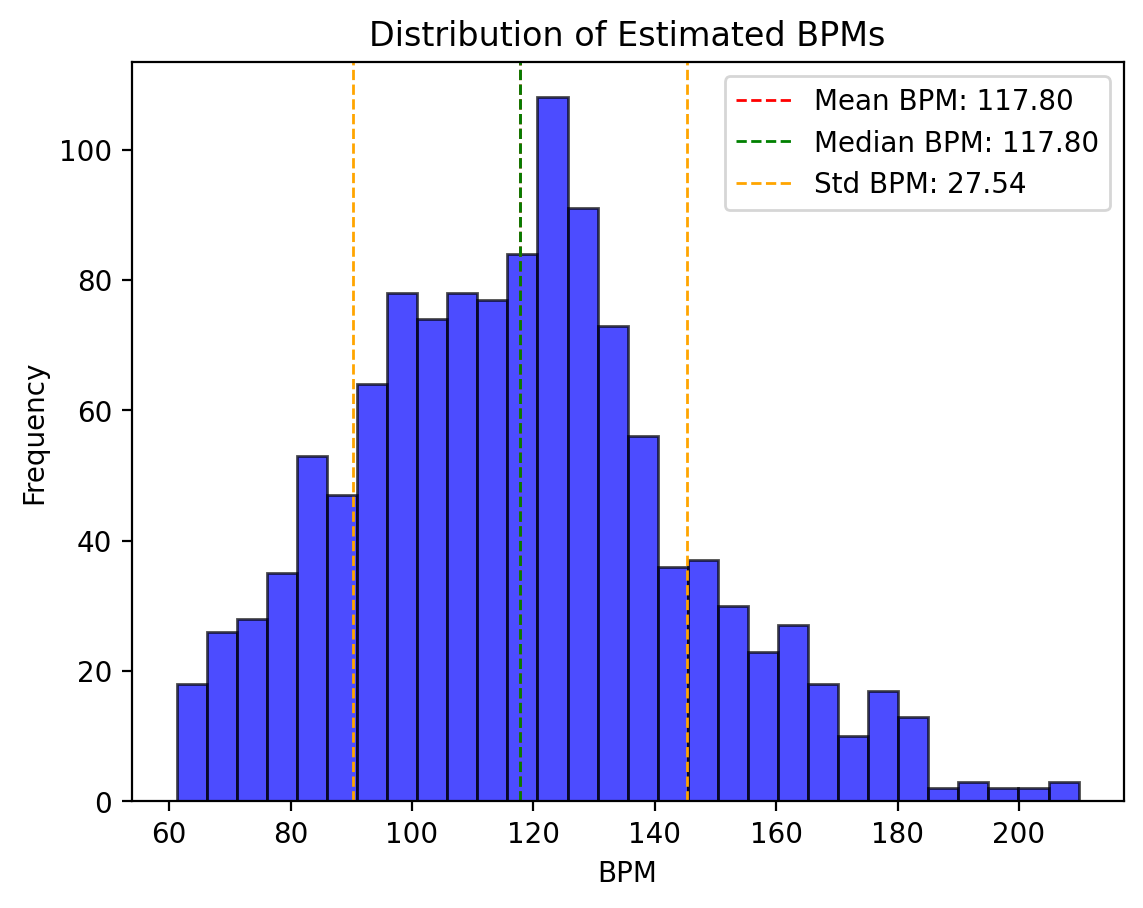

In [7]:
plt.hist(bpms, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Estimated BPMs')
plt.xlabel('BPM')
plt.ylabel('Frequency')
plt.axvline(mean_bpm, color='red', linestyle='dashed', linewidth=1, label=f'Mean BPM: {mean_bpm:.2f}')
plt.axvline(median_bpm, color='green', linestyle='dashed', linewidth=1, label=f'Median BPM: {median_bpm:.2f}')
plt.axvline(mean_bpm + std_bpm, color='orange', linestyle='dashed', linewidth=1, label=f'Std BPM: {std_bpm:.2f}')
plt.axvline(mean_bpm - std_bpm, color='orange', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

In [11]:
mean_beat_length = np.mean(beat_lengths)
std_beat_length = np.std(beat_lengths)
median_beat_length = np.median(beat_lengths)
print(f"Mean Beat Length: {mean_beat_length:.2f} seconds")
print(f"Standard Deviation of Beat Length: {std_beat_length:.2f} seconds")
print(f"Median Beat Length: {median_beat_length:.2f} seconds")

Mean Beat Length: 0.52 seconds
Standard Deviation of Beat Length: 0.13 seconds
Median Beat Length: 0.49 seconds


In [12]:
min_beat_length = np.min(beat_lengths)
max_beat_length = np.max(beat_lengths)
print(f"Minimum Beat Length: {min_beat_length:.2f} seconds")
print(f"Maximum Beat Length: {max_beat_length:.2f} seconds")

Minimum Beat Length: 0.27 seconds
Maximum Beat Length: 1.15 seconds


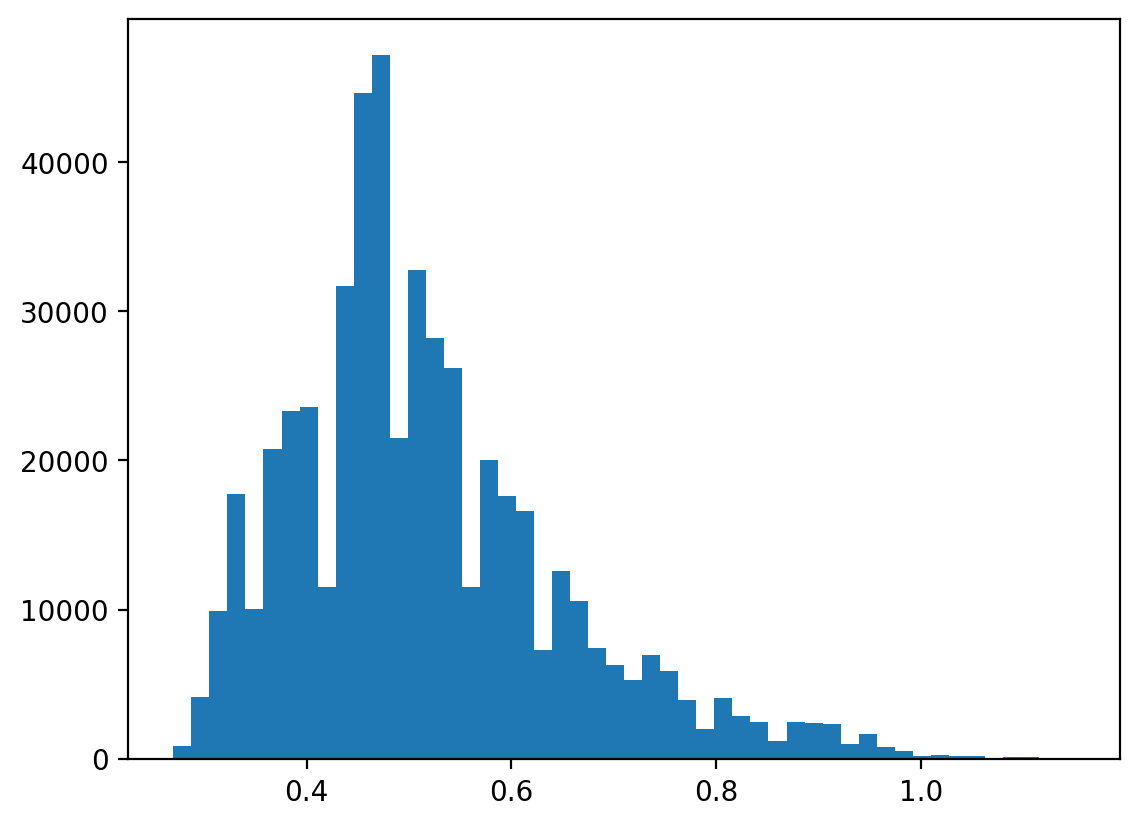

In [ ]:
plt.hist(beat_lengths, bins=50)
plt.show()

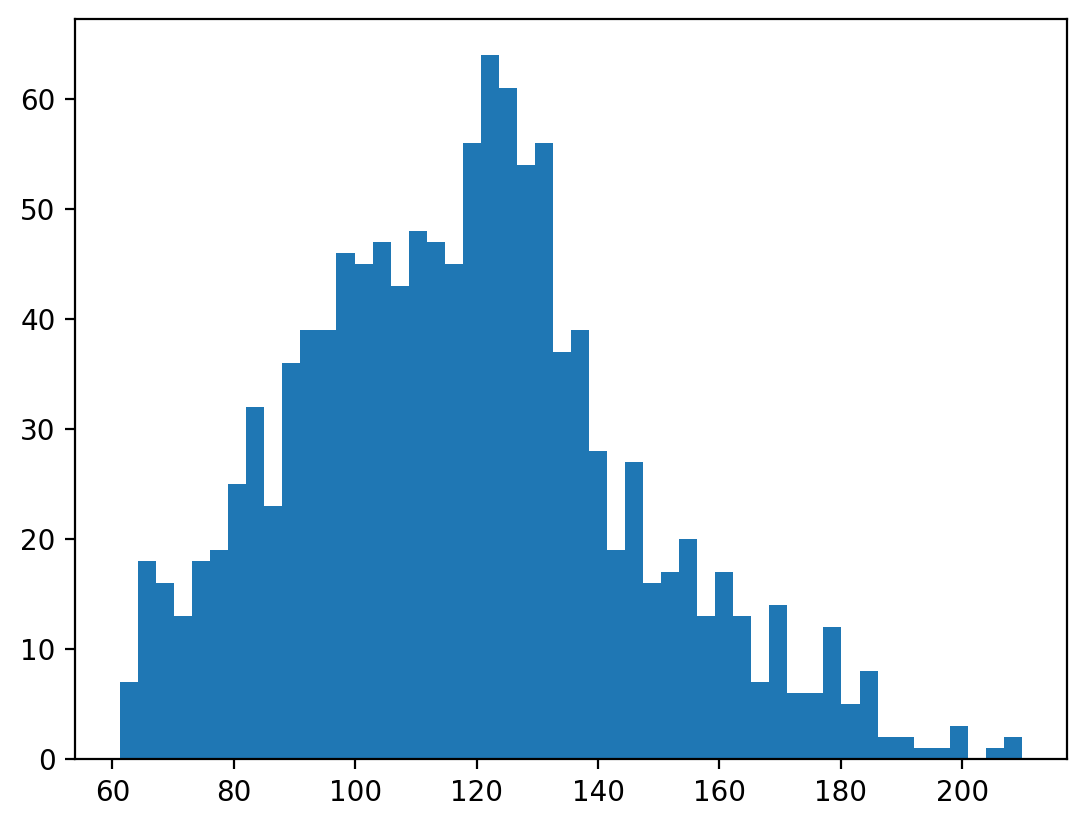

In [17]:
plt.hist(bpms, bins=50)
plt.show()

In [18]:
# Mean std of beat length WITHIN a song
stds = []
for filename in os.listdir(dir):
    if filename.endswith(".npy"):
        beats = np.load(os.path.join(dir, filename))
    
    beat_lengths = np.diff(beats)
    std_beat_length = np.std(beat_lengths)
    stds.append(std_beat_length)
mean_std = np.mean(stds)
print(f"Mean Std of Beat Length: {mean_std:.2f} seconds")

Mean Std of Beat Length: 0.03 seconds


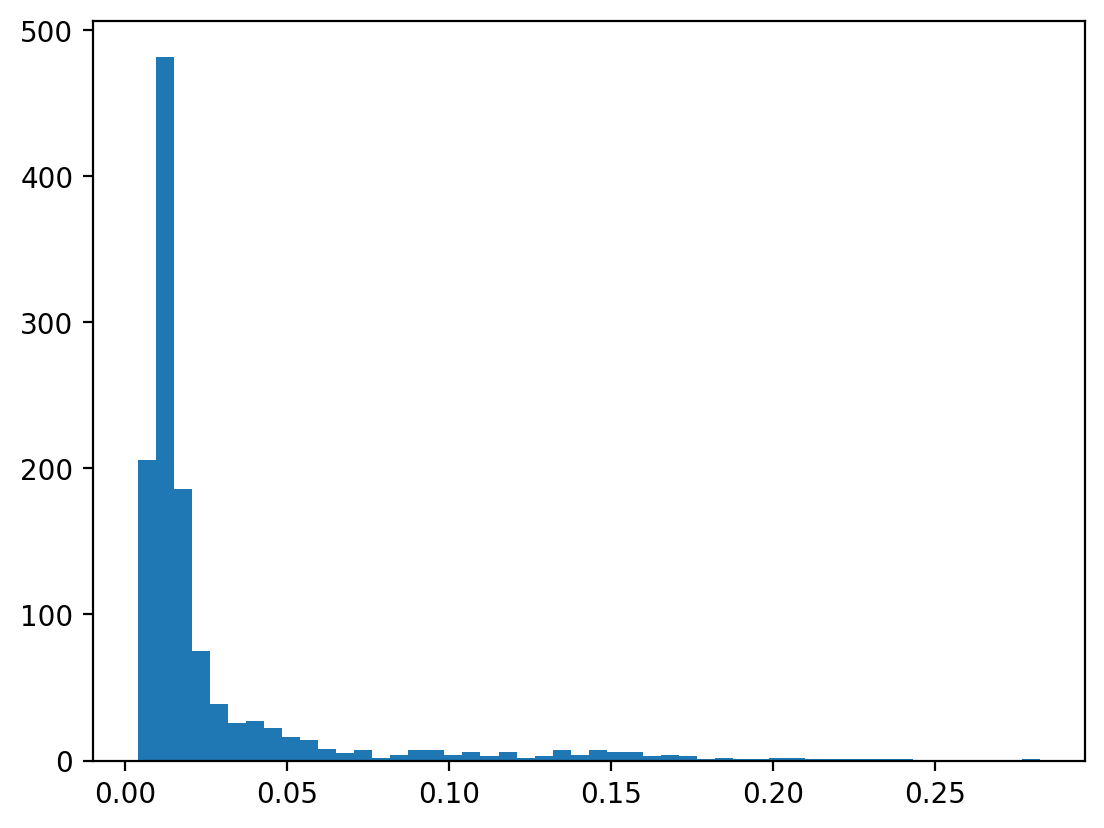

In [20]:
plt.hist(stds, bins=50)
plt.show()

### Alignment Estimation

In [ ]:
import numpy as np
from scipy.signal import correlate

def impulses_from_events(event_times, total_duration, fs=100):
    """
    Convert a list of event times into a discrete signal of impulses 
    at a given sampling rate (fs).

    Args:
        event_times (list of float): Times in seconds at which events occur.
        total_duration (float): Total duration (in seconds) to cover.
        fs (int): Sampling frequency (Hz), e.g., 100 for 0.01s resolution.

    Returns:
        np.ndarray of shape (N,): Impulse train, where N = ceil(total_duration * fs).
    """
    N = int(np.ceil(total_duration * fs))
    x = np.zeros(N, dtype=np.float32)
    for t in event_times:
        idx = int(round(t * fs))
        if 0 <= idx < N:
            x[idx] += 1
    return x

def max_corr_lag(beats, chord_boundaries, fs=100, window=1.0):
    """
    Compute cross-correlation between 'beats' and 'chord_boundaries' impulses.
    Return the lag (in seconds) at which the correlation is highest,
    restricting to +/- 1 second around 0-lag.

    Args:
        beats (list of float): Times in seconds of beat events.
        chord_boundaries (list of float): Times in seconds of chord boundary events.
        fs (int): Sampling rate for impulse trains (e.g. 100 => 0.01s resolution).

    Returns:
        float: The lag in seconds (may be positive or negative).
    """    

    max_time = 0
    max_time = max(max_time, max(beats))
    max_time = max(max_time, max(chord_boundaries))
    total_duration = max_time + 1.0  # a small margin if you want

    x_beats = impulses_from_events(beats, total_duration, fs=fs)
    y_chords = impulses_from_events(chord_boundaries, total_duration, fs=fs)

    # "full" mode => length = len(x_beats) + len(y_chords) - 1
    r_xy = correlate(x_beats, y_chords, mode='full')
    # Lags array: from -(N-1) to +(N-1)
    lags = np.arange(- (len(y_chords) - 1), len(x_beats))

    # Convert sample lags to seconds
    time_lags = lags / fs

    # Restrict to +/- 1.0 second around 0-lag
    mask = np.abs(time_lags) <= window
    restricted_r_xy = r_xy[mask]
    restricted_lags = time_lags[mask]

    # Find the lag with the maximum correlation within that window
    idx_max = np.argmax(restricted_r_xy)
    best_lag = restricted_lags[idx_max]

    return best_lag

def chord_boundaries_from_annotation(chord_annotation):
    """
    Given a chord annotation (list of Observations),
    return a sorted list of unique boundary times in seconds.
    """
    boundary_set = set()
    for obs in chord_annotation:
        start = obs.time
        end = obs.time + obs.duration
        boundary_set.add(start)
        boundary_set.add(end)
    # Convert to a sorted list
    boundaries = sorted(boundary_set)
    return boundaries

def compute_lags_for_all_files(fs=100, window=1.0):
    """
    Example loop that computes the best lag for each file in a given window around 0-lag.
    
    Args:
        all_beats_dict (dict): {filename: [list of beat times]}
        all_chords_dict (dict): {filename: [list of chord boundary times]}
        fs (int): sampling rate for impulses

    Returns:
        dict: {filename: best_lag_in_seconds} for each file.
    """
    max_lags = []
    for filename in tqdm(get_filenames()):
        ann = get_raw_chord_annotation(filename)
        chord_times = chord_boundaries_from_annotation(ann)
        beat_times = get_raw_beats(filename)
        best_lag = max_corr_lag(beat_times, chord_times, fs=fs, window=window)
        max_lags.append(best_lag)
    return max_lags


In [31]:
max_lags = compute_lags_for_all_files(fs=100, window=0.3)

100%|██████████| 1213/1213 [00:03<00:00, 307.10it/s]


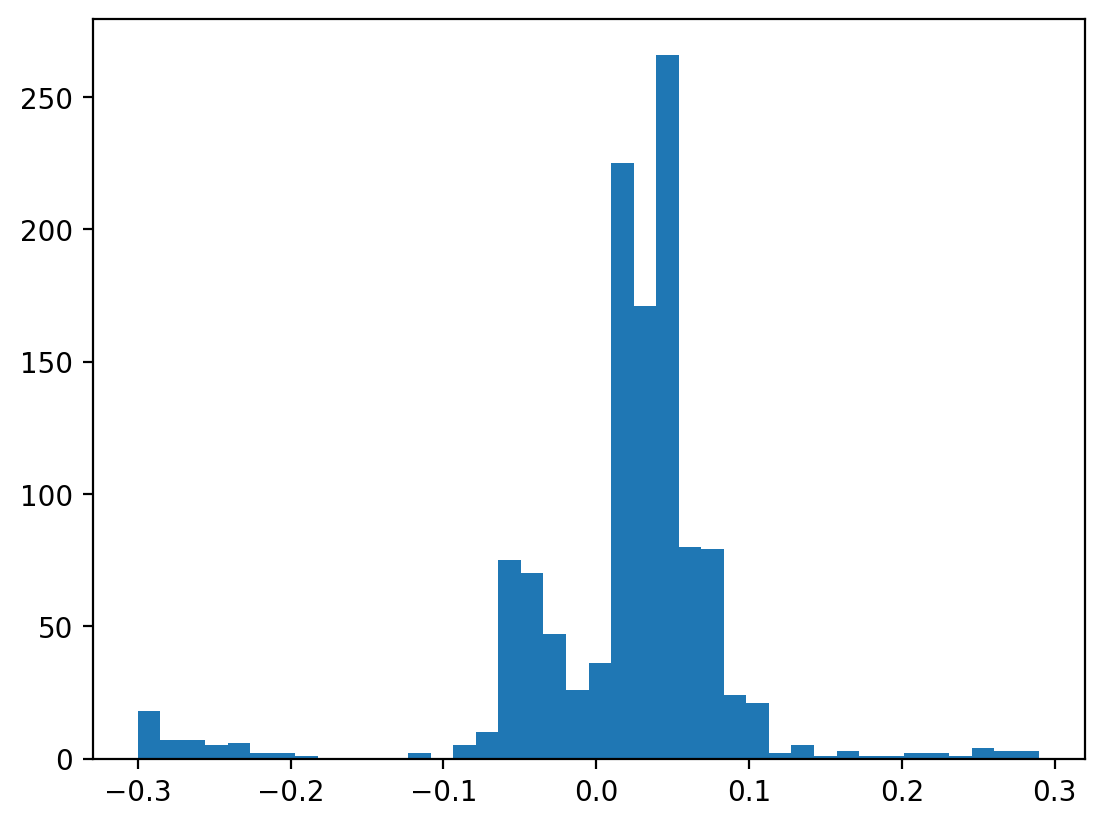

In [32]:
plt.hist(max_lags, bins=40)
plt.show()

In [5]:
fname = get_filenames()[0]
beats_example = get_raw_beats(fname)
beats_example

array([1.7000e-01, 5.7000e-01, 9.9000e-01, 1.3800e+00, 1.7800e+00,
       2.1900e+00, 2.5800e+00, 2.9700e+00, 3.3700e+00, 3.7800e+00,
       4.1900e+00, 4.5800e+00, 4.9800e+00, 5.3900e+00, 5.7900e+00,
       6.1900e+00, 6.5700e+00, 6.9800e+00, 7.3900e+00, 7.7900e+00,
       8.1800e+00, 8.5900e+00, 8.9800e+00, 9.3700e+00, 9.7600e+00,
       1.0150e+01, 1.0560e+01, 1.0950e+01, 1.1360e+01, 1.1750e+01,
       1.2140e+01, 1.2540e+01, 1.2930e+01, 1.3310e+01, 1.3700e+01,
       1.4080e+01, 1.4450e+01, 1.4840e+01, 1.5230e+01, 1.5630e+01,
       1.6030e+01, 1.6410e+01, 1.6780e+01, 1.7160e+01, 1.7530e+01,
       1.7930e+01, 1.8310e+01, 1.8680e+01, 1.9060e+01, 1.9450e+01,
       1.9820e+01, 2.0200e+01, 2.0580e+01, 2.0970e+01, 2.1350e+01,
       2.1720e+01, 2.2090e+01, 2.2480e+01, 2.2860e+01, 2.3230e+01,
       2.3600e+01, 2.3980e+01, 2.4350e+01, 2.4700e+01, 2.5070e+01,
       2.5440e+01, 2.5830e+01, 2.6200e+01, 2.6570e+01, 2.6950e+01,
       2.7330e+01, 2.7690e+01, 2.8070e+01, 2.8450e+01, 2.8820e

In [7]:
# Get length of audio of that file
import librosa
dir = './data/processed/audio'
audio_file = os.path.join(dir, f"{fname}.mp3")
y, sr = librosa.load(audio_file, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
print(f"Audio duration: {duration:.2f} seconds")

Audio duration: 215.71 seconds


In [10]:
# Print a chord annotation
from src.utils import get_raw_chord_annotation
fname = get_filenames()[0]
ann = get_raw_chord_annotation('thepolice_messageinabottle')
ann

SortedKeyList([Observation(time=0.0, duration=0.093, value='N', confidence=1.0), Observation(time=0.093, duration=0.5900000000000001, value='C#:min(*b3,9)', confidence=1.0), Observation(time=0.683, duration=0.753, value='A:maj(*3,9)', confidence=1.0), Observation(time=1.4360000000000002, duration=0.752, value='B:maj(*3,9)', confidence=1.0), Observation(time=2.188, duration=0.9410000000000001, value='F#:min(9)', confidence=1.0), Observation(time=3.129, duration=0.5750000000000001, value='C#:min(*b3,9)', confidence=1.0), Observation(time=3.704, duration=0.7370000000000001, value='A:maj(*3,9)', confidence=1.0), Observation(time=4.441, duration=0.7370000000000001, value='B:maj(*3,9)', confidence=1.0), Observation(time=5.178, duration=0.925, value='F#:min(9)', confidence=1.0), Observation(time=6.103000000000001, duration=0.5790000000000001, value='C#:min(*b3,9)', confidence=1.0), Observation(time=6.682, duration=0.7080000000000001, value='A:maj(*3,9)', confidence=1.0), Observation(time=7.39

In [11]:
get_raw_beats('thepolice_messageinabottle')

array([5.0000e-02, 4.3000e-01, 8.2000e-01, 1.1900e+00, 1.5800e+00,
       1.9600e+00, 2.3400e+00, 2.7100e+00, 3.0900e+00, 3.4600e+00,
       3.8400e+00, 4.2100e+00, 4.5900e+00, 4.9600e+00, 5.3300e+00,
       5.7000e+00, 6.0700e+00, 6.4500e+00, 6.8300e+00, 7.2000e+00,
       7.5800e+00, 7.9600e+00, 8.3300e+00, 8.7100e+00, 9.0900e+00,
       9.4700e+00, 9.8400e+00, 1.0210e+01, 1.0580e+01, 1.0950e+01,
       1.1320e+01, 1.1700e+01, 1.2080e+01, 1.2460e+01, 1.2840e+01,
       1.3200e+01, 1.3580e+01, 1.3940e+01, 1.4300e+01, 1.4670e+01,
       1.5040e+01, 1.5410e+01, 1.5760e+01, 1.6140e+01, 1.6500e+01,
       1.6870e+01, 1.7230e+01, 1.7600e+01, 1.7980e+01, 1.8350e+01,
       1.8710e+01, 1.9080e+01, 1.9460e+01, 1.9810e+01, 2.0190e+01,
       2.0560e+01, 2.0930e+01, 2.1290e+01, 2.1650e+01, 2.2010e+01,
       2.2370e+01, 2.2730e+01, 2.3100e+01, 2.3470e+01, 2.3850e+01,
       2.4220e+01, 2.4580e+01, 2.4950e+01, 2.5320e+01, 2.5690e+01,
       2.6060e+01, 2.6430e+01, 2.6790e+01, 2.7160e+01, 2.7530e